In [1]:
import pandas as pd
import numpy as np
pd.set_option('max_colwidth', 1000)

from sklearn.model_selection import train_test_split
import cv2

import os
from pathlib import Path
import shutil
from tqdm.notebook import tqdm
tqdm.pandas()

import multiprocessing
from IPython.core.display import HTML
from IPython.display import Image
from collections import Counter
import json

from plotly.offline import init_notebook_mode, iplot
import matplotlib.pyplot as plt
init_notebook_mode(connected=True)
%matplotlib inline
import plotly.graph_objs as go
import plotly.express as px
from plotly import tools
import seaborn as sns

from wordcloud import WordCloud
from PIL import Image

In [2]:
DATA_DIR = Path('/kaggle/input/ghana-crop-disease')
IMAGE_DIR = Path('/kaggle/input/ghana-crop-disease/images')

In [3]:
def display_image_by_id(image_id):
    # Construct the file path
    image_path = os.path.join(IMAGE_DIR, f"{image_id}.jpg")
    
    # Check if the file exists
    if os.path.exists(image_path):
        # Load the image
        image = Image.open(image_path)
        
        # Display the image
        plt.figure(figsize=(5, 5))
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"Image_ID: {image_id}")
        plt.show()
    else:
        print(f"Image with ID {image_id} not found.")

In [4]:
train = pd.read_csv(DATA_DIR / 'Train.csv')
test = pd.read_csv(DATA_DIR / 'Test.csv')
ss = pd.read_csv(DATA_DIR / 'SampleSubmission.csv')

In [5]:
train["plant"] = train["class"].apply(lambda x: x.split("_")[0])
train["disease"] = train["class"].apply(lambda x: "_".join(x.split("_")[1:]))

In [6]:
train.groupby("plant").agg({'Image_ID': ['nunique', 'count'], 'disease': ['nunique', "unique"]})

Image_ID        disease  \
        nunique  count nunique   
plant                            
Corn       1409  13128       5   
Pepper     2365  10745      10   
Tomato     1281  17156       8   

                                                                                                                                   
                                                                                                                           unique  
plant                                                                                                                              
Corn                                                   [Cercospora_Leaf_Spot, Common_Rust, Streak, Healthy, Northern_Leaf_Blight]  
Pepper  [Bacterial_Spot, Fusarium, Septoria, Leaf_Curl, Leaf_Mosaic, Healthy, Late_Blight, Cercospora, Leaf_Blight, Early_Blight]  
Tomato                                [Early_Blight, Septoria, Healthy, Late_Blight, Fusarium, Leaf_Curl, Bacterial_Spot, Mosaic]

In [7]:
pd.crosstab(train.plant, train.disease).T

plant,Corn,Pepper,Tomato
disease,,,
Bacterial_Spot,0,1943,484
Cercospora,0,472,0
Cercospora_Leaf_Spot,6538,0,0
Common_Rust,1682,0,0
Early_Blight,0,101,1946
Fusarium,0,472,882
Healthy,1571,736,2872
Late_Blight,0,575,3918
Leaf_Blight,0,508,0


In [8]:
train.groupby("Image_ID")["plant"].nunique().value_counts()

plant
1    4749
2     153
Name: count, dtype: int64

In [9]:
images_with_two_plants = train.groupby("Image_ID")["plant"].nunique()[train.groupby("Image_ID")["plant"].nunique()==2].index.tolist()
train.loc[train.Image_ID.isin(images_with_two_plants)].groupby("Image_ID")['plant'].unique().apply(lambda x: sorted(x)).value_counts()

plant
[Pepper, Tomato]    153
Name: count, dtype: int64

In [10]:
train.groupby("Image_ID")["disease"].nunique().value_counts()

disease
1    3923
2     873
3     101
4       5
Name: count, dtype: int64

In [11]:
images_with_two_disease = train.groupby("Image_ID")["disease"].nunique()[train.groupby("Image_ID")["disease"].nunique() == 2].index.tolist()
train.loc[train.Image_ID.isin(images_with_two_disease)].groupby("Image_ID")['disease'].unique().apply(lambda x: sorted(x)).value_counts()

disease
[Cercospora_Leaf_Spot, Common_Rust]             131
[Late_Blight, Septoria]                         125
[Cercospora_Leaf_Spot, Healthy]                  78
[Leaf_Curl, Leaf_Mosaic]                         70
[Bacterial_Spot, Leaf_Mosaic]                    66
[Cercospora_Leaf_Spot, Streak]                   51
[Early_Blight, Late_Blight]                      39
[Northern_Leaf_Blight, Streak]                   35
[Fusarium, Healthy]                              23
[Healthy, Leaf_Curl]                             20
[Leaf_Blight, Leaf_Curl]                         19
[Fusarium, Late_Blight]                          18
[Leaf_Blight, Leaf_Mosaic]                       17
[Cercospora, Leaf_Curl]                          16
[Cercospora, Leaf_Blight]                        14
[Bacterial_Spot, Leaf_Curl]                      14
[Leaf_Curl, Mosaic]                              14
[Common_Rust, Healthy]                           13
[Bacterial_Spot, Late_Blight]                    13
[Cer

In [12]:
images_with_three_disease = train.groupby("Image_ID")["disease"].nunique()[train.groupby("Image_ID")["disease"].nunique() == 3].index.tolist()
train.loc[train.Image_ID.isin(images_with_three_disease)].groupby("Image_ID")['disease'].unique().apply(lambda x: sorted(x)).value_counts()

disease
[Cercospora_Leaf_Spot, Common_Rust, Healthy]                 15
[Early_Blight, Late_Blight, Septoria]                        12
[Bacterial_Spot, Early_Blight, Late_Blight]                  10
[Cercospora_Leaf_Spot, Northern_Leaf_Blight, Streak]          8
[Leaf_Curl, Mosaic, Septoria]                                 7
[Cercospora_Leaf_Spot, Healthy, Streak]                       6
[Cercospora_Leaf_Spot, Common_Rust, Streak]                   5
[Cercospora_Leaf_Spot, Common_Rust, Northern_Leaf_Blight]     4
[Bacterial_Spot, Fusarium, Leaf_Mosaic]                       4
[Common_Rust, Northern_Leaf_Blight, Streak]                   3
[Cercospora, Leaf_Curl, Leaf_Mosaic]                          3
[Healthy, Northern_Leaf_Blight, Streak]                       3
[Cercospora, Healthy, Leaf_Mosaic]                            3
[Healthy, Leaf_Curl, Mosaic]                                  2
[Bacterial_Spot, Healthy, Leaf_Curl]                          2
[Cercospora, Leaf_Blight, Leaf_C

In [13]:
images_with_four_disease = train.groupby("Image_ID")["disease"].nunique()[train.groupby("Image_ID")["disease"].nunique() == 4].index.tolist()
train.loc[train.Image_ID.isin(images_with_four_disease)].groupby("Image_ID")['disease'].unique().apply(lambda x: sorted(x)).value_counts()

disease
[Bacterial_Spot, Early_Blight, Late_Blight, Septoria]                1
[Cercospora_Leaf_Spot, Common_Rust, Northern_Leaf_Blight, Streak]    1
[Early_Blight, Healthy, Late_Blight, Leaf_Curl]                      1
[Cercospora_Leaf_Spot, Common_Rust, Healthy, Streak]                 1
[Early_Blight, Fusarium, Late_Blight, Leaf_Curl]                     1
Name: count, dtype: int64

In [14]:
healthy_and_diseased_ids = train.groupby("Image_ID").filter(
    lambda group: "Healthy" in group["disease"].values and len(group["disease"].unique()) > 1
)["Image_ID"].unique()

train[train["Image_ID"].isin(healthy_and_diseased_ids)]

,Image_ID,confidence,class,ymin,xmin,ymax,xmax,plant,disease
66,id_15f2s1.jpg,1.0,Corn_Healthy,1033.233250,981.337009,1370.629881,1763.032391,Corn,Healthy
67,id_15f2s1.jpg,1.0,Corn_Healthy,997.781541,1168.972746,1374.104523,1525.366876,Corn,Healthy
68,id_15f2s1.jpg,1.0,Corn_Healthy,529.949943,1999.228119,1612.430800,3506.381806,Corn,Healthy
69,id_15f2s1.jpg,1.0,Corn_Healthy,1388.359181,3093.501048,1818.849864,3960.251572,Corn,Healthy
70,id_15f2s1.jpg,1.0,Corn_Healthy,782.997416,47.801516,1075.407829,711.399035,Corn,Healthy
...,...,...,...,...,...,...,...,...,...
40941,id_fcmy3h.jpg,1.0,Corn_Healthy,245.974445,3438.897312,403.426206,3641.350793,Corn,Healthy
40948,id_4344u7.jpg,1.0,Tomato_Healthy,2272.923848,77.554846,2622.836611,515.620210,Tomato,Healthy
40974,id_1sq66k.jpg,1.0,Pepper_Cercospora,1629.168331,3045.689397,1653.354633,3071.897464,Pepper,Cercospora
41022,id_rp4ezm.jpg,1.0,Corn_Cercospora_Leaf_Spot,1314.397109,2496.926258,1409.992822,2586.905582,Corn,Cercospora_Leaf_Spot


In [15]:
# Find the IDs with "Healthy" and other diseases
grouped = train.groupby("Image_ID")["disease"]
mask = grouped.transform(
    lambda x: "Healthy" in x.values and len(x.unique()) > 1
)

train[mask].head(40)

,Image_ID,confidence,class,ymin,xmin,ymax,xmax,plant,disease
66,id_15f2s1.jpg,1.0,Corn_Healthy,1033.233250,981.337009,1370.629881,1763.032391,Corn,Healthy
67,id_15f2s1.jpg,1.0,Corn_Healthy,997.781541,1168.972746,1374.104523,1525.366876,Corn,Healthy
68,id_15f2s1.jpg,1.0,Corn_Healthy,529.949943,1999.228119,1612.430800,3506.381806,Corn,Healthy
69,id_15f2s1.jpg,1.0,Corn_Healthy,1388.359181,3093.501048,1818.849864,3960.251572,Corn,Healthy
70,id_15f2s1.jpg,1.0,Corn_Healthy,782.997416,47.801516,1075.407829,711.399035,Corn,Healthy
71,id_15f2s1.jpg,1.0,Corn_Common_Rust,698.433715,2831.194969,1163.135578,3894.675052,Corn,Common_Rust
72,id_15f2s1.jpg,1.0,Corn_Healthy,1185.943032,2289.475891,1582.222535,2865.408805,Corn,Healthy
285,id_1dkvrb.jpg,1.0,Tomato_Leaf_Curl,190.126390,791.917116,378.786653,1180.037062,Tomato,Leaf_Curl
286,id_1dkvrb.jpg,1.0,Tomato_Leaf_Curl,264.898888,95.923181,428.058645,277.833558,Tomato,Leaf_Curl
287,id_1dkvrb.jpg,1.0,Tomato_Healthy,792.087968,277.641509,1153.640040,748.918464,Tomato,Healthy


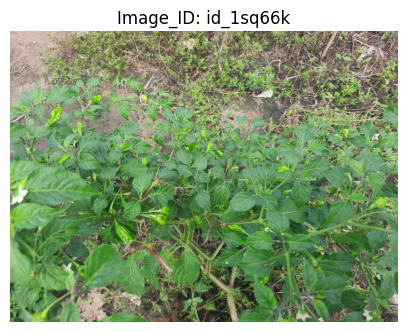

In [16]:
display_image_by_id("id_1sq66k")